# A Galaxy Lacking Dark Matter (?)

The code in this notebook reproduces an estimate for the velocity dispersion of the ultra-diffuse galaxy NGC1052–DF2 presented in a paper by [van Dokkum et al. (2018)](https://arxiv.org/abs/1803.10237), and checks that result using a different technique (as [suggested by N. Martin](https://twitter.com/nfmartin1980/status/982245161735372804) and others).

In [ ]:
from astropy.stats import biweight_scale
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.interpolate import interp1d
from scipy.stats import percentileofscore
import theano.tensor as T

In [2]:
# see Fig. 5 in the paper
df = pd.read_csv("data.csv")

In [3]:
df

,id,v,v_err
0,GC-39,14.728960,7.046859
1,GC-59,-3.892651,15.641404
2,GC-71,2.048405,6.883926
3,GC-73,10.576495,3.258663
4,GC-77,1.171631,5.906327
5,GC-85,-1.907788,5.376794
6,GC-91,-1.212140,9.694343
7,GC-92,-14.320283,6.761636
8,GC-98,-39.335900,12.586586
9,GC-101,-3.375351,13.523452


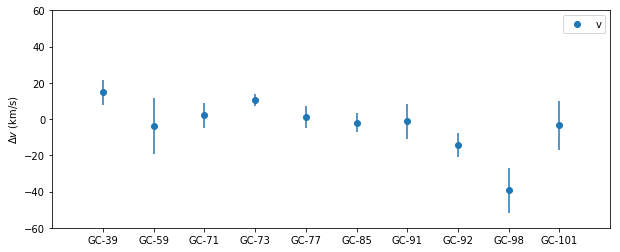

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))
df.plot(ax=ax, x=df.index, y="v", yerr="v_err", marker="o", linestyle="none")
ax.set_xticks(df.index)
ax.set_xticklabels(df["id"])
ax.set_xlim([-1, 10])
ax.set_ylim([-60, 60])
ax.set_ylabel(r"$\Delta v$ (km/s)")
plt.show()

## Method 1:

In [5]:
# robust estimate of the observed velocity dispersion
sigma_obs = biweight_scale(df["v"])

In [6]:
print(f"sigma_obs = {sigma_obs:.2f}")

sigma_obs = 8.54


In [7]:
def estimate_sigma(sigma_test, n_sample=5000):
    sigma_test_obs = np.empty(n_sample)
    
    for n in range(n_sample):
        v_tracer = np.random.normal(0, sigma_test, size=len(df))
    
        for i, v_err in enumerate(df["v_err"]):
            v_tracer[i] += np.random.normal(0, v_err)
        
        sigma_test_obs[n] = biweight_scale(v_tracer)
        
    return sigma_test_obs

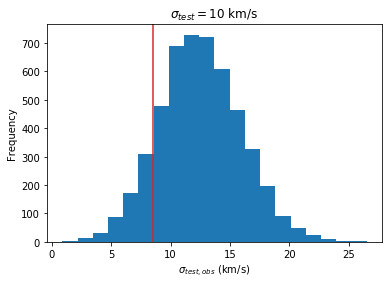

In [8]:
fig, ax = plt.subplots()
ax.hist(estimate_sigma(sigma_test=10), bins=20)
ax.axvline(sigma_obs, color="C3")
ax.set_xlabel(r"$\sigma_{test,obs}$ (km/s)")
ax.set_ylabel(r"Frequency")
ax.set_title(r"$\sigma_{test}=10$ km/s")
plt.show()

In [9]:
def get_percentile(sigma_test, sigma_obs):
    sigma_test_obs = estimate_sigma(sigma_test)
    return percentileofscore(sigma_test_obs, sigma_obs)  

sigma_test = np.linspace(1, 20, 50)
p_sigma_test = np.array([get_percentile(sigma, sigma_obs) for sigma in sigma_test])

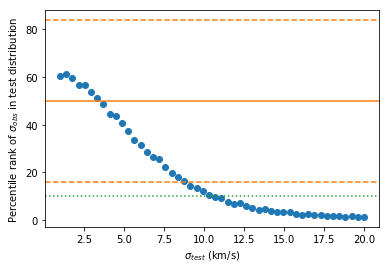

In [10]:
fig, ax = plt.subplots()
ax.scatter(sigma_test, p_sigma_test)
ax.axhline(50, color="C1")
ax.axhline(16, color="C1", linestyle="--")
ax.axhline(84, color="C1", linestyle="--")
ax.axhline(10, color="C2", linestyle=":")
ax.set_xlabel(r"$\sigma_{test}$ (km/s)")
ax.set_ylabel(r"Percentile rank of $\sigma_{obs}$ in test distribution")
plt.show()

In [11]:
f_inv = interp1d(p_sigma_test, sigma_test)
print(f"sigma < {f_inv(10):.2f} km/s at 90% confidence")

sigma < 10.55 km/s at 90% confidence


## Method 2:

In [12]:
with pm.Model() as model:
    mean = pm.Uniform("mean", -50, 50)
    log_sigma = pm.Uniform("log_sigma", np.log(0.1), np.log(50))
    
    v_tracer = pm.Normal("v_tracer", mu=mean, sd=df["v_err"], shape=len(df))
    
    v_obs = pm.Normal("v_obs", mu=v_tracer, sd=T.exp(log_sigma), observed=df["v"])
    
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_tracer, log_sigma_interval__, mean_interval__]
100%|██████████| 11000/11000 [00:29<00:00, 374.29it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


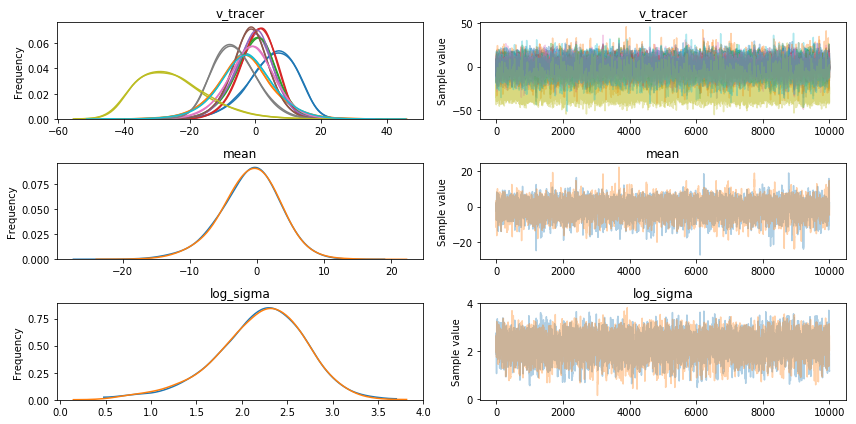

In [13]:
pm.traceplot(trace)
plt.show()

In [14]:
sigma = np.exp(trace["log_sigma"])

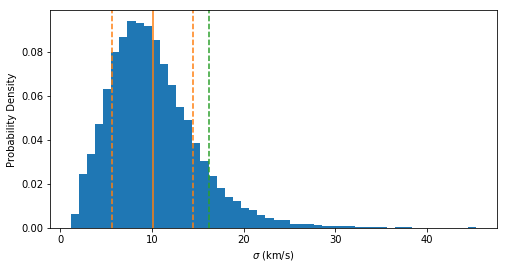

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(sigma, bins=50, density=True)
ax.axvline(np.mean(sigma), color="C1")
ax.axvline(np.percentile(sigma, 16), color="C1", linestyle="--")
ax.axvline(np.percentile(sigma, 84), color="C1", linestyle="--")
ax.axvline(np.percentile(sigma, 90), color="C2", linestyle="--")
ax.set_xlabel(r"$\sigma$ (km/s)")
ax.set_ylabel("Probability Density")
plt.show()

In [16]:
print(f"sigma < {np.percentile(sigma, 90):.2f} km/s at 90% confidence")

sigma < 16.23 km/s at 90% confidence


In [17]:
print(f"sigma < 10 km/s at {percentileofscore(sigma, 10):.0f}% confidence")

sigma < 10 km/s at 55% confidence


In [18]:
# when excluding the most extreme measurement:
# df = df.drop(8) # GC-98
# sigma < 10.86 km/s at 90% confidence
# sigma < 10 km/s at 86% confidence